In [1]:
%load_ext watermark


In [2]:
import itertools as it
import os

from downstream import dstream
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

import pylib  # noqa: F401


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-01-26T16:38:56.704125+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.5.0-1025-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot   : 1.2.0
polars    : 1.9.0
seaborn   : 0.13.2
downstream: 1.6.2
pylib     : 0.0.0

Watermark: 2.4.3



In [4]:
teeplot_subdir = os.environ.get(
    "NOTEBOOK_NAME", "2024-10-20-qos-dstream-vs-naive-steady"
)
teeplot_subdir


'2025-01-18-qos-dstream-vs-naive-steady'

In [5]:
buffer_size = 64
num_items = 10_000


## Define


In [6]:
def calc_max_gaps_naive_greedy(
    buffer_size: int, num_ingests: int
) -> list[int]:
    segment_lengths = []
    max_gaps = []
    for i in range(num_ingests):
        segment_lengths.append(1)
        if len(segment_lengths) > buffer_size:
            target = min(
                reversed(range(buffer_size)),
                key=lambda i: segment_lengths[i] + segment_lengths[i + 1],
            )
            segment_lengths[target] += segment_lengths[target + 1]
            segment_lengths.pop(target + 1)
        max_gaps.append(max(segment_lengths) - 1)
        assert sum(segment_lengths) == i + 1
    return max_gaps


In [7]:
def calc_max_gaps_naive_zhao_2006(
    buffer_size: int, num_ingests: int
) -> list[int]:
    segment_lengths = []
    max_gaps = []
    for i in range(num_ingests):
        if len(segment_lengths) < buffer_size:
            segment_lengths.append(1)
            max_gaps.append(max(segment_lengths) - 1)
            continue
        if (
            len(segment_lengths) > 2
            and segment_lengths[-1] < segment_lengths[-2]
        ):
            segment_lengths[-1] += 1
        else:
            target = min(
                range(buffer_size - 1),
                key=lambda i: segment_lengths[i] + segment_lengths[i + 1],
            )
            segment_lengths[target] += segment_lengths[target + 1]
            segment_lengths.pop(target + 1)
            segment_lengths.append(1)

        assert sum(segment_lengths) == i + 1
        max_gaps.append(max(segment_lengths) - 1)
    return max_gaps


In [8]:
def calc_max_gaps_dstream(buffer_size: int, num_items: int) -> list[int]:
    return [
        max(
            b - a - 1
            for a, b in it.pairwise(
                [
                    *sorted(
                        dstream.steady_algo.lookup_ingest_times_eager(
                            buffer_size, i + 1
                        ),
                    ),
                    i,
                ],
            )
        )
        if i >= buffer_size
        else 0
        for i in range(num_items)
    ]


## Example Plot


In [9]:
df = pl.concat(
    [
        pl.DataFrame(
            {
                # "Algorithm": "naive steady Zhao06",
                "Algorithm": "naive steady",
                "Max Gap Size": calc_max_gaps_naive_zhao_2006(
                    buffer_size, num_items
                ),
                "Num Items Ingested": range(num_items),
            },
        ),
        pl.DataFrame(
            {
                "Algorithm": "naive steady greedy",
                "Max Gap Size": calc_max_gaps_naive_greedy(
                    buffer_size, num_items
                ),
                "Num Items Ingested": range(num_items),
            },
        ),
        pl.DataFrame(
            {
                "Algorithm": "dstream steady",
                "Max Gap Size": calc_max_gaps_dstream(buffer_size, num_items),
                "Num Items Ingested": range(num_items),
            },
        ),
    ],
)


teeplots/2025-01-18-qos-dstream-vs-naive-steady/exclude=naive steady greedy+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/exclude=naive steady greedy+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


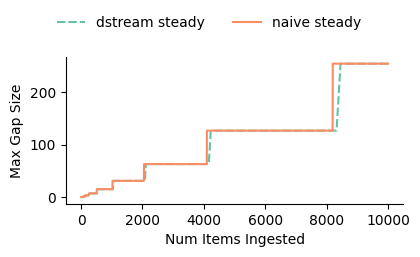

teeplots/2025-01-18-qos-dstream-vs-naive-steady/exclude=+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.pdf
teeplots/2025-01-18-qos-dstream-vs-naive-steady/exclude=+hue=algorithm+kind=line+palette=set2+style=algorithm+viz=relplot+x=num-items-ingested+y=max-gap-size+ext=.png


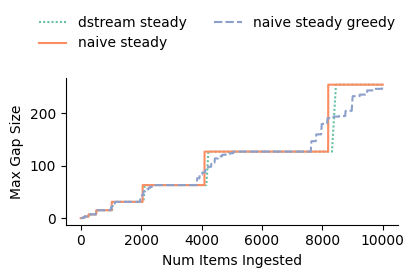

In [10]:
for exclude in ["naive steady greedy", ""]:
    with tp.teed(
        sns.relplot,
        df.filter(
            pl.col("Algorithm") != exclude,
        ),
        x="Num Items Ingested",
        y="Max Gap Size",
        hue="Algorithm",
        hue_order=[
            v
            for v in ("dstream steady", "naive steady", "naive steady greedy")
            if v != exclude
        ],
        style="Algorithm",
        aspect=2,
        kind="line",
        height=2.2,
        palette="Set2",
        teeplot_outattrs={"exclude": exclude},
        teeplot_subdir=teeplot_subdir,
    ) as g:
        sns.move_legend(
            g,
            "lower center",
            bbox_to_anchor=(0.4, 1),
            ncol=2,
            title=None,
            frameon=False,
        )
